In [1]:
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

#import lhsmdu #install in terminal 'pip install lhsmdu'
import matplotlib.pyplot as plt
import pickle

import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt

from InterpFromGridToMesh import InterpFromGridToMesh
from InterpFromMeshToMesh2d import InterpFromMeshToMesh2d

In [7]:
region = 'SAtoES'
start_year  = 1985.

Opening ./Models/SAtoES_friction_coefficient.nc for reading 
group toolkits is empty
empty init
Opening ./Models/SAtoES_inversion.nc for reading 
empty init


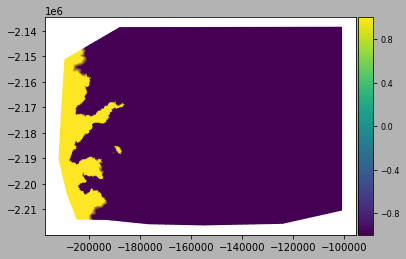

In [2]:
# Load a separate model to extract the friction coefficient and rheology
md_friction = loadmodel("./Models/SAtoES_friction_coefficient.nc")
friction_coefficient = md_friction.results.StressbalanceSolution.FrictionCoefficient
rheology_B = md_friction.materials.rheology_B
md_friction = None

# Load the original model
md = loadmodel("./Models/SAtoES_inversion.nc")
md.friction.coefficient = friction_coefficient
md.materials.rheology_B = rheology_B

md.levelset.spclevelset = np.nan * np.ones((md.mesh.numberofvertices))
pos = md.mesh.vertexonboundary == 1
#pos = np.where(md.mesh.vertexonboundary)
md.levelset.spclevelset[pos] = md.mask.ice_levelset[pos]
md.levelset.migration_max = 1e10
plotmodel(md, 'data', md.mask.ice_levelset)

In [8]:
## Relaxation
relaxation_years = 1 #try 5 years if 1 runs quickly

# Special post-processing of inverted friction coefficient
filename = 'Exp/' + region + '_coeffront_after_inversion.exp'
if os.path.isfile(filename):
  print('adjusting inverted friction coefficient at the glacier fronts')
  pos = find(ContourToNodes(md.mesh.x, md.mesh.y, filename, 1))
  md.friction.coefficient[pos] = 10

md.initialization.pressure = np.zeros([md.mesh.numberofvertices,1])
md.initialization.temperature = 250*np.ones([md.mesh.numberofvertices,1]) #temperature is in kelvin

# Set parameters
md.inversion.iscontrol=0;
md.timestepping.start_time = start_year;
md.timestepping.time_step  = .02;
md.timestepping.final_time = start_year + relaxation_years;
md.settings.output_frequency = (1/md.timestepping.time_step)/5; # 5/yr

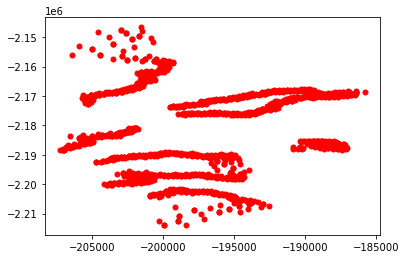

In [9]:
# define fjord walls/flush where bed > 0 (code added 8/3/22)
n_buffer = 2
for i in range(n_buffer):
    elements = md.mesh.elements.astype(int)-1
    nodes_edge = elements[np.where(np.sum(md.mask.ice_levelset[elements] == -1, axis=1) == 2)[0]]
    nodes_edge = np.unique(nodes_edge.ravel())
    nodes_bed = np.where(md.geometry.bed > 0)[0]
    nodes_edge_bed = np.array(list(set(nodes_edge) & set(nodes_bed)))
    plt.plot(md.mesh.x[nodes_edge_bed], md.mesh.y[nodes_edge_bed], 'r.', markersize=10)

    md.mask.ice_levelset[nodes_edge_bed] = -1
    md.geometry.thickness[nodes_edge_bed] = 10
    md.geometry.surface[nodes_edge_bed] = md.geometry.bed[nodes_edge_bed] + md.geometry.thickness[nodes_edge_bed]

    md.friction.coefficient[nodes_edge_bed] = 200

In [10]:
# defining thermal and sub. discharge at every ISSM mesh node 

# load raster of basins
ds = gdal.Open('./Cheat_matfiles/tidewaterbasins_rignotid.mat_tidewaterbasins.tif', gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
basins_array = rb.ReadAsArray()

gt = ds.GetGeoTransform()
ulx, xres, xskew, uly, yskew, yres  = gt
lrx = ulx + (ds.RasterXSize * xres)
lry = uly + (ds.RasterYSize * yres)
x = np.arange(ulx, lrx,  xres)
y = np.arange(lry, uly, -yres)

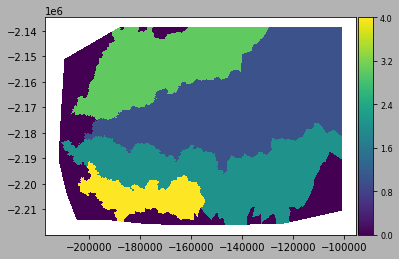

In [11]:
# interpolate basin to each mesh node 
px = np.array( ((md.mesh.x - gt[0]) / gt[1]).astype(int) )
py = np.array( ((md.mesh.y - gt[3]) / gt[5]).astype(int) )

basins_mesh = basins_array[py.astype(int), px.astype(int)]

# ISSM wants basins to be numbered from 1 to 4 with the basins that we don't care about numbered 0
basins_mesh[basins_mesh==13] = 1
basins_mesh[basins_mesh==52] = 2
basins_mesh[basins_mesh==53] = 3
basins_mesh[basins_mesh==90] = 4
basins_mesh[(basins_mesh<1) | (basins_mesh>4)] = 0

# find basin id for each element
basins_elements = basins_mesh[md.mesh.elements-1]
basins_elements = np.max(basins_elements, axis=1)

plotmodel(md, 'data', basins_elements)

In [12]:
# Assigning ocean thermal (EN4) and subglacial discharge (RACMO2.3p2) forcings
from scipy_io_utils import *

# Load historical forcing data
glacier_list = list()
m = loadmat('./Cheat_matfiles/glacier0013.mat')
glacier0013 = m['glacier0013']
m = loadmat('./Cheat_matfiles/glacier0052.mat')
glacier0052 = m['glacier0052']
m = loadmat('./Cheat_matfiles/glacier0053.mat')
glacier0053 = m['glacier0053']
m = loadmat('./Cheat_matfiles/glacier0090.mat')
glacier0090 = m['glacier0090']

# Thermal forcing
t = glacier0013['EN4']['t']
TF = glacier0013['EN4']['TF']

# Discharge
t = glacier0013['RACMO']['Q']
Q = glacier0013['RACMO']['Q']

from frontalforcingsrignot import frontalforcingsrignot
md.frontalforcings = frontalforcingsrignot()
valid = ~np.isnan(glacier0013['EN4']['TF'])
md.frontalforcings.thermalforcing = np.zeros( (md.mesh.numberofvertices+1, len(glacier0013['EN4']['TF'][valid])) )
md.frontalforcings.subglacial_discharge = np.zeros( (md.mesh.numberofvertices+1, len(glacier0013['RACMO']['Q'])) )

In [13]:
# Assign forcings to correct node 

# step 1: find which nodes belong to each basin using basin_mesh
get_indexes = lambda basins_mesh, xs: [i for (y, i) in zip(xs, range(len(xs))) if basins_mesh == y]
glacier13_nodes = get_indexes(1,basins_mesh)
glacier52_nodes = get_indexes(2,basins_mesh)
glacier53_nodes = get_indexes(3,basins_mesh)
glacier90_nodes = get_indexes(4,basins_mesh)

# NOTE: Denis combined steps 2 and 3: we select the rows and set to the TF time series
# step 2: select() rows from frontalforcings.thermal that correspond to step 1 nodes
md.frontalforcings.thermalforcing[glacier13_nodes,:] = glacier0013['EN4']['TF'][valid]
md.frontalforcings.thermalforcing[glacier52_nodes,:] = glacier0052['EN4']['TF'][valid]
md.frontalforcings.thermalforcing[glacier53_nodes,:] = glacier0053['EN4']['TF'][valid]
md.frontalforcings.thermalforcing[glacier90_nodes,:] = glacier0090['EN4']['TF'][valid]

# step 2: select() rows from frontalforcings.subglacial_discharge that correspond to step 1 nodes
md.frontalforcings.subglacial_discharge[glacier13_nodes,:] = glacier0013['RACMO']['Q'] * 86400
md.frontalforcings.subglacial_discharge[glacier52_nodes,:] = glacier0052['RACMO']['Q'] * 86400
md.frontalforcings.subglacial_discharge[glacier53_nodes,:] = glacier0053['RACMO']['Q'] * 86400
md.frontalforcings.subglacial_discharge[glacier90_nodes,:] = glacier0090['RACMO']['Q'] * 86400

# NOTE: And now, set the last row to the time
md.frontalforcings.thermalforcing[-1,:] = glacier0013['EN4']['t'][valid]
md.frontalforcings.subglacial_discharge[-1,:] = glacier0013['RACMO']['t']

# NOTE: All times are the same for the TF time series for each glacier so we just set the times equal to the glacier0013 times


In [36]:
# We set the transient parameters
md.transient.ismovingfront=1
md.transient.isthermal=0
md.transient.isstressbalance=1
md.transient.ismasstransport=1
md.transient.isgroundingline=1
md.groundingline.migration = 'SubelementMigration'

# We set the ocean conditions
md.frontalforcings.basin_id = basins_elements
md.frontalforcings.num_basins = 4

# We set the calving model
from calvingvonmises import calvingvonmises
md.calving = calvingvonmises()

# Set the requested outputs
md.stressbalance.requested_outputs=['default']
md.transient.requested_outputs=['default','IceVolumeAboveFloatation','BasalforcingsGroundediceMeltingRate','CalvingMeltingrate']

# Localhost
from socket import gethostname
from generic import generic
md.cluster = generic('name', gethostname(), 'np', 4)
md.settings.waitonlock = np.inf
md.cluster.interactive = 0

# SMCE cluster
from eis_nasa_smce import eis_nasa_smce
md.cluster = eis_nasa_smce()
md.cluster.partition = 'sealevel-c5xl-spot'
md.cluster.login = 'dfelikso'
md.cluster.idfile = '~/.ssh/id_rsa'
md.cluster.executionpath = '/efs/dfelikso/'

md.settings.waitonlock = 0

# Go solve
md.verbose.solution=1
from solve import solve
md = solve(md, 'tr')


eis_nasa_smce_settings.py not found, using default settings
checking model consistency
marshalling file SAtoES.bin
uploading input file and queueing script
launching solution sequence on remote cluster


You are accessing a U.S. Government information system, which includes, 1. this computer, 2. this computer network, 3. all computers connected to this network including end user systems, 4. all devices and storage media attached to this network or to any computer on this network and 5.cloud and remote information services. This information system is provided for U.S. Government-authorized use only. You have no reasonable expectation of privacy regarding any communication transmitted through or data stored on this information system. At any time, and for any lawful purpose, the U.S. Government may monitor, intercept, search, and seize any communication or data transiting, stored on, or traveling to or from this information system. You are NOT authorized to process classified information on this information system. Unauthorized or improper use of this system may result in suspension or loss of access privileges, disciplinary action, and civil and/or criminal penalties.



Submitted batch job 32663
Model results must be loaded manually with md = loadresultsfromcluster(md).


In [64]:
# Check on the status of the run on the cluster
#!ssh dfelikso@52.10.233.96 '/opt/slurm/bin/squeue | grep dfelikso'

from loadresultsfromcluster import loadresultsfromcluster
md = loadresultsfromcluster(md)


You are accessing a U.S. Government information system, which includes, 1. this computer, 2. this computer network, 3. all computers connected to this network including end user systems, 4. all devices and storage media attached to this network or to any computer on this network and 5.cloud and remote information services. This information system is provided for U.S. Government-authorized use only. You have no reasonable expectation of privacy regarding any communication transmitted through or data stored on this information system. At any time, and for any lawful purpose, the U.S. Government may monitor, intercept, search, and seize any communication or data transiting, stored on, or traveling to or from this information system. You are NOT authorized to process classified information on this information system. Unauthorized or improper use of this system may result in suspension or loss of access privileges, disciplinary action, and civil and/or criminal penalties.



In [15]:
# Save the model out to a netCDF
from export_netCDF import export_netCDF

md.results.StressbalanceSolution = None
md.inversion.cost_functions = md.inversion.cost_functions.astype(np.float64)
for i in range(len(md.results.TransientSolution)):
    md.results.TransientSolution[i].step = np.float64(md.results.TransientSolution[i].step)

export_netCDF(md, '/efs/dfelikso/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/test.nc')

File /efs/dfelikso/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/test.nc allready exist


Give a new name or "delete" to replace:  delete


field md.solidearth.external is None


/efs/issm-new/python-modules/repos/trunk-jpl-working/src/m/contrib/defleurian/netCDF/export_netCDF.py:394: RuntimeWarning: invalid value encountered in remainder
  IsInt = np.sum(np.mod(var, 1)) == 0 and np.all(abs(var) < 2147483647) and len(var) > 0


WARNING type "int16" is unknown for "frontalforcings.basin_id"
qmu is skipped until it is more stable
field md.results.StressbalanceSolution is None
TransientSolution


Text(0.5, 0, 'thickness change (m)')

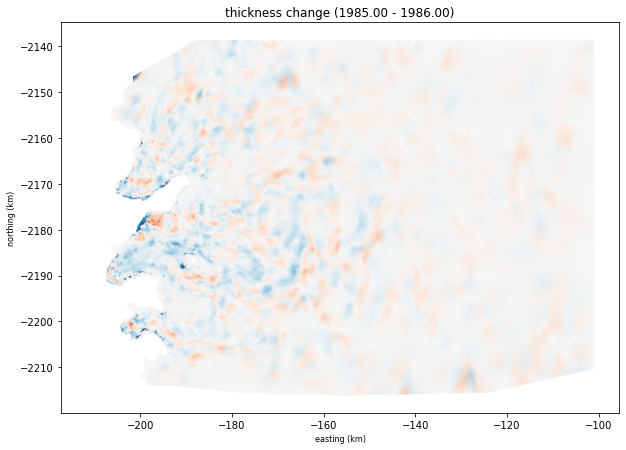

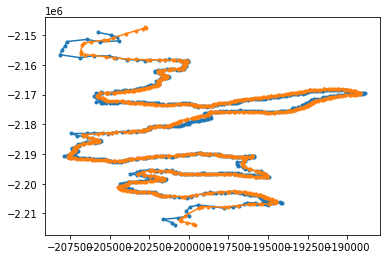

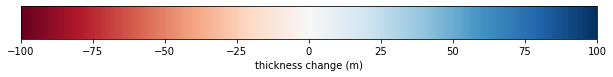

In [27]:
# Plot change in ice thickness
cmap = 'RdBu'

plot_step_start =  0
plot_step_end   = -1

thickness_change = md.results.TransientSolution[plot_step_end].Thickness[:,0] - md.geometry.thickness

fig = plt.figure(figsize=(10,10))
vmin = -100
vmax = +100
plotmodel(md, 'data', thickness_change, 'mask', md.results.TransientSolution[plot_step_end].MaskIceLevelset<=0, \
         'colormap', cmap, 'caxis', [vmin, vmax], 'colorbar', 'off', \
         'unit', 'km', 'xlabel', 'easting (km)', 'ylabel', 'northing (km)', \
         'backgroundcolor', 'white')

plt.title('thickness change ({:6.2f} - {:6.2f})'.format(md.timestepping.start_time, md.results.TransientSolution[plot_step_end].time))

# Plot start/end ice extent contours
fig = plt.figure()
from contourlevelzero import contourlevelzero
contours = contourlevelzero(md, md.mask.ice_levelset, 0)
plt.plot(contours[0]['x'], contours[0]['y'], '.-')
contours = contourlevelzero(md, md.results.TransientSolution[plot_step_end].MaskIceLevelset, 0)
plt.plot(contours[0]['x'], contours[0]['y'], '.-')

# Colorbar as a separate plot
a = np.array([[vmin,vmax]])
plt.figure(figsize=(10, 0.75))
img = plt.imshow(a, cmap=cmap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation='horizontal', cax=cax)
plt.xlabel('thickness change (m)')
